# Error characterization for actively tracked catheter in a dynamic phantom

Data processing and plotting functions are defined in dynamic_utils

Only the JPNG algorithm for this experiment is analysed in the manuscript, but the centroid-around-peak algorithm data is also processed below.

# Imports

In [2]:
from catheter_utils import geometry
from dynamic_utils import *
import pandas as pd
import os

%matplotlib inline

# Constants and Paths

In [3]:
# Main data paths for each catheter (manually input)
prepend = '/data/activeTracking-reorg1' # Change to empty string after zenodo get
parent_path = prepend + '/data/processed/dynamic/'
if (not os.path.isdir(parent_path)):
    print("Using precomputed outputs")
    parent_path = '../data/preprocessed/dynamic/'

catheter_paths = ['catheter231/', 'catheter299/', 'catheter306/']
main_paths = [parent_path + cath for cath in catheter_paths]

# Ground truth paths (to manually input)
GT_filename_home = [d + 'gt/home/GroundTruthCoords.csv' for d in main_paths] 
GT_filename_pos15 = [d + 'gt/p15/GroundTruthCoords.csv' for d in main_paths]
GT_filename_neg15 = [d + 'gt/n15/GroundTruthCoords.csv' for d in main_paths]
GT_filename_pos5 = [d + 'gt/p5/GroundTruthCoords.csv' for d in main_paths]
GT_filename_neg5 = [d + 'gt/n5/GroundTruthCoords.csv' for d in main_paths]

results_path = '../reports/figures/dynamic/'
# Where you would like to save the comparison plots (manually input)
comparison_plot_paths = [results_path + 'comparisonPlots/' + cath for cath in catheter_paths]

# Where you would like to save the box plots (manually input)
box_plot_path = results_path + 'boxPlots/'

export_path = '../reports/export/dynamic/'
os.makedirs(export_path, exist_ok=True)

sequences = ['HM', '3P']
cap = 'centroid_around_peak'
jpng = 'jpng'

# Recordings for each motion profile
recordings = [ [ {'{}'.format(sequences[0]): '0001',
                  '{}'.format(sequences[1]): '0001'},
                
                 {'{}'.format(sequences[0]): '0002',
                  '{}'.format(sequences[1]): '0002'} ],
                
               [ {'{}'.format(sequences[0]): '0001',
                  '{}'.format(sequences[1]): '0001'}, 
                 
                 {'{}'.format(sequences[0]): '0002',
                  '{}'.format(sequences[1]): '0002'} ],
                
               [ {'{}'.format(sequences[0]): '0001',
                  '{}'.format(sequences[1]): '0001'},
                
                 {'{}'.format(sequences[0]): '0002',
                  '{}'.format(sequences[1]): '0002'} ] ]

# Get ground truth info
GT_home_coords_dfs = [get_gt_coords(GT_filename_home[0]), get_gt_coords(GT_filename_home[1]), get_gt_coords(GT_filename_home[2])]
GT_pos15_coords_dfs = [get_gt_coords(GT_filename_pos15[0]), get_gt_coords(GT_filename_pos15[1]), get_gt_coords(GT_filename_pos15[2])]
GT_neg15_coords_dfs = [get_gt_coords(GT_filename_neg15[0]), get_gt_coords(GT_filename_neg15[1]), get_gt_coords(GT_filename_neg15[2])]
GT_pos5_coords_dfs = [get_gt_coords(GT_filename_pos5[0]), get_gt_coords(GT_filename_pos5[1]), get_gt_coords(GT_filename_pos5[2])]
GT_neg5_coords_dfs = [get_gt_coords(GT_filename_neg5[0]), get_gt_coords(GT_filename_neg5[1]), get_gt_coords(GT_filename_neg5[2])]

# Constant Numerical Values

In [4]:
num_caths = 3
num_profs = 4

# Coil numbers
distal_index = 6
proximal_index = 7

# Amplitudes and periods
amplitude_resp = 15 # mm
period_resp = 4024 # ms

amplitude_card = 5 # mm
period_card = 1006 # ms

# Device geometry index
geometry_index = 1 # 1 for catheter, 2 for dilator

# Start indices for each motion profile

start_idx = [ [ {'{}'.format(sequences[0]): 98,
                 '{}'.format(sequences[1]): 43}, 
                        
                {'{}'.format(sequences[0]): 63,
                 '{}'.format(sequences[1]): 48} ], 

              [ {'{}'.format(sequences[0]): 88,
                 '{}'.format(sequences[1]): 52}, 
                        
                {'{}'.format(sequences[0]): 81,
                 '{}'.format(sequences[1]): 45} ], 

              [ {'{}'.format(sequences[0]): 62,
                 '{}'.format(sequences[1]): 35}, 
                        
                {'{}'.format(sequences[0]): 60,
                 '{}'.format(sequences[1]): 31} ] ]

# Ground Truth coordinates
Images were acquired with the fixture holding the catheter tips at the motion stage locations: -15 mm, -5 mm, 0 mm (home), 5 mm, and 15 mm, for each of 3 catheters. These have been manually labelled to get ground truth coordinates for these locations.

Below, these are saved into arrays for each position and coil. So the home_dist_coords array contains the coordinates of the distal coils of the three catheters at the home position. Each catheter was set up in the scanner in a separate scan session, so these coordinates are different.

In [5]:
# Get ground truth distal coords
temp_dfs = [GT_home_coords_dfs[0].set_index(['Coil']), GT_home_coords_dfs[1].set_index(['Coil']), GT_home_coords_dfs[2].set_index(['Coil'])]
home_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

temp_dfs = [GT_pos15_coords_dfs[0].set_index(['Coil']), GT_pos15_coords_dfs[1].set_index(['Coil']), GT_pos15_coords_dfs[2].set_index(['Coil'])]
pos15_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

temp_dfs = [GT_neg15_coords_dfs[0].set_index(['Coil']), GT_neg15_coords_dfs[1].set_index(['Coil']), GT_neg15_coords_dfs[2].set_index(['Coil'])]
neg15_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

temp_dfs = [GT_pos5_coords_dfs[0].set_index(['Coil']), GT_pos5_coords_dfs[1].set_index(['Coil']), GT_pos5_coords_dfs[2].set_index(['Coil'])]
pos5_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

temp_dfs = [GT_neg5_coords_dfs[0].set_index(['Coil']), GT_neg5_coords_dfs[1].set_index(['Coil']), GT_neg5_coords_dfs[2].set_index(['Coil'])]
neg5_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

# Get ground truth proximal coords
temp_dfs = [GT_home_coords_dfs[0].set_index(['Coil']), GT_home_coords_dfs[1].set_index(['Coil']), GT_home_coords_dfs[2].set_index(['Coil'])]
home_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

temp_dfs = [GT_pos15_coords_dfs[0].set_index(['Coil']), GT_pos15_coords_dfs[1].set_index(['Coil']), GT_pos15_coords_dfs[2].set_index(['Coil'])]
pos15_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

temp_dfs = [GT_neg15_coords_dfs[0].set_index(['Coil']), GT_neg15_coords_dfs[1].set_index(['Coil']), GT_neg15_coords_dfs[2].set_index(['Coil'])]
neg15_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

temp_dfs = [GT_pos5_coords_dfs[0].set_index(['Coil']), GT_pos5_coords_dfs[1].set_index(['Coil']), GT_pos5_coords_dfs[2].set_index(['Coil'])]
pos5_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

temp_dfs = [GT_neg5_coords_dfs[0].set_index(['Coil']), GT_neg5_coords_dfs[1].set_index(['Coil']), GT_neg5_coords_dfs[2].set_index(['Coil'])]
neg5_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

# Calculate unit vectors using distal/proximal coords
unit_vectors_from_dist_resp = np.abs([calc_unit_vector(home_dist_coords[0], pos15_dist_coords[0], neg15_dist_coords[0]), calc_unit_vector(home_dist_coords[1], pos15_dist_coords[1], neg15_dist_coords[1]), calc_unit_vector(home_dist_coords[2], pos15_dist_coords[2], neg15_dist_coords[2])])
unit_vectors_from_prox_resp = np.abs([calc_unit_vector(home_prox_coords[0], pos15_prox_coords[0], neg15_prox_coords[0]), calc_unit_vector(home_prox_coords[1], pos15_prox_coords[1], neg15_prox_coords[1]), calc_unit_vector(home_prox_coords[2], pos15_prox_coords[2], neg15_prox_coords[2])])
unit_vectors_from_dist_card = np.abs([calc_unit_vector(home_dist_coords[0], pos5_dist_coords[0], neg5_dist_coords[0]), calc_unit_vector(home_dist_coords[1], pos5_dist_coords[1], neg5_dist_coords[1]), calc_unit_vector(home_dist_coords[2], pos5_dist_coords[2], neg5_dist_coords[2])])
unit_vectors_from_prox_card = np.abs([calc_unit_vector(home_prox_coords[0], pos5_prox_coords[0], neg5_prox_coords[0]), calc_unit_vector(home_prox_coords[1], pos5_prox_coords[1], neg5_prox_coords[1]), calc_unit_vector(home_prox_coords[2], pos5_prox_coords[2], neg5_prox_coords[2])])

unit_vectors_from_dist_resp[0][0] = -1 * unit_vectors_from_dist_resp[0][0] # Need to do this for some reason

In [6]:
home_dist_coords # home position [x,y,z] coordinates of the distal coil of catheters 231, 299, and 306 respectively

[array([-11.39996969,  77.54392743, -29.79419598]),
 array([ -7.56396322,  78.40214253, -27.82464852]),
 array([-24.5409068 ,  80.22939404, -30.99722142])]

# Dataframes for Coil Tracking Data
The catheter coordinates during motion have been recorded and saved for each sequence and algorithm into text files.

These are converted into data frames for each sequence, catheter, coil, and motion profile for both the JPNG and centroid-around-peak algorithms.

In [7]:
# Convert coil cathcoords to dataframes

# Sequence 1: Hadamard Multiplexed - JPNG
FH512_2_jpng_6_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[0], jpng, distal_index,   recordings[0][0][sequences[0]])
FH512_2_jpng_7_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[0], jpng, proximal_index, recordings[0][0][sequences[0]])
FH512_2_jpng_6_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[0], jpng, distal_index,   recordings[0][1][sequences[0]])
FH512_2_jpng_7_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[0], jpng, proximal_index, recordings[0][1][sequences[0]])

FH512_2_jpng_6_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[0], jpng, distal_index,   recordings[1][0][sequences[0]])
FH512_2_jpng_7_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[0], jpng, proximal_index, recordings[1][0][sequences[0]])
FH512_2_jpng_6_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[0], jpng, distal_index,   recordings[1][1][sequences[0]])
FH512_2_jpng_7_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[0], jpng, proximal_index, recordings[1][1][sequences[0]])

FH512_2_jpng_6_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[0], jpng, distal_index,   recordings[2][0][sequences[0]])
FH512_2_jpng_7_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[0], jpng, proximal_index, recordings[2][0][sequences[0]])
FH512_2_jpng_6_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[0], jpng, distal_index,   recordings[2][1][sequences[0]])
FH512_2_jpng_7_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[0], jpng, proximal_index, recordings[2][1][sequences[0]])

# Sequence 1: Hadamard Multiplexed - CAP
FH512_2_cap_6_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[0], cap, distal_index,   recordings[0][0][sequences[0]])
FH512_2_cap_7_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[0], cap, proximal_index, recordings[0][0][sequences[0]])
FH512_2_cap_6_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[0], cap, distal_index,   recordings[0][1][sequences[0]])
FH512_2_cap_7_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[0], cap, proximal_index, recordings[0][1][sequences[0]])

FH512_2_cap_6_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[0], cap, distal_index,   recordings[1][0][sequences[0]])
FH512_2_cap_7_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[0], cap, proximal_index, recordings[1][0][sequences[0]])
FH512_2_cap_6_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[0], cap, distal_index,   recordings[1][1][sequences[0]])
FH512_2_cap_7_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[0], cap, proximal_index, recordings[1][1][sequences[0]])

FH512_2_cap_6_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[0], cap, distal_index,   recordings[2][0][sequences[0]])
FH512_2_cap_7_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[0], cap, proximal_index, recordings[2][0][sequences[0]])
FH512_2_cap_6_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[0], cap, distal_index,   recordings[2][1][sequences[0]])
FH512_2_cap_7_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[0], cap, proximal_index, recordings[2][1][sequences[0]])

# Sequence 2: Conventional - JPNG
SRI_2_jpng_6_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[1], jpng, distal_index,   recordings[0][0][sequences[1]])
SRI_2_jpng_7_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[1], jpng, proximal_index, recordings[0][0][sequences[1]])
SRI_2_jpng_6_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[1], jpng, distal_index,   recordings[0][1][sequences[1]])
SRI_2_jpng_7_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[1], jpng, proximal_index, recordings[0][1][sequences[1]])

SRI_2_jpng_6_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[1], jpng, distal_index,   recordings[1][0][sequences[1]])
SRI_2_jpng_7_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[1], jpng, proximal_index, recordings[1][0][sequences[1]])
SRI_2_jpng_6_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[1], jpng, distal_index,   recordings[1][1][sequences[1]])
SRI_2_jpng_7_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[1], jpng, proximal_index, recordings[1][1][sequences[1]])

SRI_2_jpng_6_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[1], jpng, distal_index,   recordings[2][0][sequences[1]])
SRI_2_jpng_7_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[1], jpng, proximal_index, recordings[2][0][sequences[1]])
SRI_2_jpng_6_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[1], jpng, distal_index,   recordings[2][1][sequences[1]])
SRI_2_jpng_7_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[1], jpng, proximal_index, recordings[2][1][sequences[1]])

# Sequence 2: Conventional - CAP
SRI_2_cap_6_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[1], cap, distal_index,   recordings[0][0][sequences[1]])
SRI_2_cap_7_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[1], cap, proximal_index, recordings[0][0][sequences[1]])
SRI_2_cap_6_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[1], cap, distal_index,   recordings[0][1][sequences[1]])
SRI_2_cap_7_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[1], cap, proximal_index, recordings[0][1][sequences[1]])

SRI_2_cap_6_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[1], cap, distal_index,   recordings[1][0][sequences[1]])
SRI_2_cap_7_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[1], cap, proximal_index, recordings[1][0][sequences[1]])
SRI_2_cap_6_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[1], cap, distal_index,   recordings[1][1][sequences[1]])
SRI_2_cap_7_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[1], cap, proximal_index, recordings[1][1][sequences[1]])

SRI_2_cap_6_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[1], cap, distal_index,   recordings[2][0][sequences[1]])
SRI_2_cap_7_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[1], cap, proximal_index, recordings[2][0][sequences[1]])
SRI_2_cap_6_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[1], cap, distal_index,   recordings[2][1][sequences[1]])
SRI_2_cap_7_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[1], cap, proximal_index, recordings[2][1][sequences[1]])

# Dataframes for Tip Tracking Data

The distal and proximal coils for each combination (sequence, algorithm, catheter, and motion profile) are used to calculate the tip coordinates using extrapolation.

In [8]:
# Get tip coords from tracked data

# Sequence 1: Hadamard Multiplexed - JPNG
FH512_2_jpng_tip_231_resp = get_tip_coords(FH512_2_jpng_7_231_resp, FH512_2_jpng_6_231_resp, geometry_index)
FH512_2_jpng_tip_231_card = get_tip_coords(FH512_2_jpng_7_231_card, FH512_2_jpng_6_231_card, geometry_index)

FH512_2_jpng_tip_299_resp = get_tip_coords(FH512_2_jpng_7_299_resp, FH512_2_jpng_6_299_resp, geometry_index)
FH512_2_jpng_tip_299_card = get_tip_coords(FH512_2_jpng_7_299_card, FH512_2_jpng_6_299_card, geometry_index)

FH512_2_jpng_tip_306_resp = get_tip_coords(FH512_2_jpng_7_306_resp, FH512_2_jpng_6_306_resp, geometry_index)
FH512_2_jpng_tip_306_card = get_tip_coords(FH512_2_jpng_7_306_card, FH512_2_jpng_6_306_card, geometry_index)

# Sequence 1: Hadamard Multiplexed - CAP
FH512_2_cap_tip_231_resp = get_tip_coords(FH512_2_cap_7_231_resp, FH512_2_cap_6_231_resp, geometry_index)
FH512_2_cap_tip_231_card = get_tip_coords(FH512_2_cap_7_231_card, FH512_2_cap_6_231_card, geometry_index)

FH512_2_cap_tip_299_resp = get_tip_coords(FH512_2_cap_7_299_resp, FH512_2_cap_6_299_resp, geometry_index)
FH512_2_cap_tip_299_card = get_tip_coords(FH512_2_cap_7_299_card, FH512_2_cap_6_299_card, geometry_index)

FH512_2_cap_tip_306_resp = get_tip_coords(FH512_2_cap_7_306_resp, FH512_2_cap_6_306_resp, geometry_index)
FH512_2_cap_tip_306_card = get_tip_coords(FH512_2_cap_7_306_card, FH512_2_cap_6_306_card, geometry_index)

# Sequence 2: Conventional - JPNG
SRI_2_jpng_tip_231_resp = get_tip_coords(SRI_2_jpng_7_231_resp, SRI_2_jpng_6_231_resp, geometry_index)
SRI_2_jpng_tip_231_card = get_tip_coords(SRI_2_jpng_7_231_card, SRI_2_jpng_6_231_card, geometry_index)

SRI_2_jpng_tip_299_resp = get_tip_coords(SRI_2_jpng_7_299_resp, SRI_2_jpng_6_299_resp, geometry_index)
SRI_2_jpng_tip_299_card = get_tip_coords(SRI_2_jpng_7_299_card, SRI_2_jpng_6_299_card, geometry_index)

SRI_2_jpng_tip_306_resp = get_tip_coords(SRI_2_jpng_7_306_resp, SRI_2_jpng_6_306_resp, geometry_index)
SRI_2_jpng_tip_306_card = get_tip_coords(SRI_2_jpng_7_306_card, SRI_2_jpng_6_306_card, geometry_index)

# Sequence 2: Conventional - CAP
SRI_2_cap_tip_231_resp = get_tip_coords(SRI_2_cap_7_231_resp, SRI_2_cap_6_231_resp, geometry_index)
SRI_2_cap_tip_231_card = get_tip_coords(SRI_2_cap_7_231_card, SRI_2_cap_6_231_card, geometry_index)

SRI_2_cap_tip_299_resp = get_tip_coords(SRI_2_cap_7_299_resp, SRI_2_cap_6_299_resp, geometry_index)
SRI_2_cap_tip_299_card = get_tip_coords(SRI_2_cap_7_299_card, SRI_2_cap_6_299_card, geometry_index)

SRI_2_cap_tip_306_resp = get_tip_coords(SRI_2_cap_7_306_resp, SRI_2_cap_6_306_resp, geometry_index)
SRI_2_cap_tip_306_card = get_tip_coords(SRI_2_cap_7_306_card, SRI_2_cap_6_306_card, geometry_index)


# Dataframes for Ground Truth (Expected) Coil Data

Expected positions for the catheter coils can be calculated from the ground truth start position, direction of motion, timestamps, and programmed motion profile. These are calculated for the JPNG & centroid-about-peak algorithms for both sequences and motion profiles.

In [9]:
# Get expected coil coords for each sequence

# Sequence 1: Hadamard Multiplexed - JPNG
FH512_2_jpng_6_expected_231_resp = get_expected_coords_resp(FH512_2_jpng_6_231_resp, start_idx[0][0][sequences[0]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_resp, period_resp)
FH512_2_jpng_7_expected_231_resp = get_expected_coords_resp(FH512_2_jpng_7_231_resp, start_idx[0][0][sequences[0]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_resp, period_resp)
FH512_2_jpng_6_expected_231_card = get_expected_coords_card(FH512_2_jpng_6_231_card, start_idx[0][1][sequences[0]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_card, period_card)
FH512_2_jpng_7_expected_231_card = get_expected_coords_card(FH512_2_jpng_7_231_card, start_idx[0][1][sequences[0]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_card, period_card)

FH512_2_jpng_6_expected_299_resp = get_expected_coords_resp(FH512_2_jpng_6_299_resp, start_idx[1][0][sequences[0]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_resp, period_resp)
FH512_2_jpng_7_expected_299_resp = get_expected_coords_resp(FH512_2_jpng_7_299_resp, start_idx[1][0][sequences[0]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_resp, period_resp)
FH512_2_jpng_6_expected_299_card = get_expected_coords_card(FH512_2_jpng_6_299_card, start_idx[1][1][sequences[0]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_card, period_card)
FH512_2_jpng_7_expected_299_card = get_expected_coords_card(FH512_2_jpng_7_299_card, start_idx[1][1][sequences[0]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_card, period_card)

FH512_2_jpng_6_expected_306_resp = get_expected_coords_resp(FH512_2_jpng_6_306_resp, start_idx[2][0][sequences[0]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_resp, period_resp)
FH512_2_jpng_7_expected_306_resp = get_expected_coords_resp(FH512_2_jpng_7_306_resp, start_idx[2][0][sequences[0]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_resp, period_resp)
FH512_2_jpng_6_expected_306_card = get_expected_coords_card(FH512_2_jpng_6_306_card, start_idx[2][1][sequences[0]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_card, period_card)
FH512_2_jpng_7_expected_306_card = get_expected_coords_card(FH512_2_jpng_7_306_card, start_idx[2][1][sequences[0]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_card, period_card)

# Sequence 1: Hadamard Multiplexed - CAP
FH512_2_cap_6_expected_231_resp = get_expected_coords_resp(FH512_2_cap_6_231_resp, start_idx[0][0][sequences[0]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_resp, period_resp)
FH512_2_cap_7_expected_231_resp = get_expected_coords_resp(FH512_2_cap_7_231_resp, start_idx[0][0][sequences[0]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_resp, period_resp)
FH512_2_cap_6_expected_231_card = get_expected_coords_card(FH512_2_cap_6_231_card, start_idx[0][1][sequences[0]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_card, period_card)
FH512_2_cap_7_expected_231_card = get_expected_coords_card(FH512_2_cap_7_231_card, start_idx[0][1][sequences[0]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_card, period_card)

FH512_2_cap_6_expected_299_resp = get_expected_coords_resp(FH512_2_cap_6_299_resp, start_idx[1][0][sequences[0]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_resp, period_resp)
FH512_2_cap_7_expected_299_resp = get_expected_coords_resp(FH512_2_cap_7_299_resp, start_idx[1][0][sequences[0]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_resp, period_resp)
FH512_2_cap_6_expected_299_card = get_expected_coords_card(FH512_2_cap_6_299_card, start_idx[1][1][sequences[0]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_card, period_card)
FH512_2_cap_7_expected_299_card = get_expected_coords_card(FH512_2_cap_7_299_card, start_idx[1][1][sequences[0]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_card, period_card)

FH512_2_cap_6_expected_306_resp = get_expected_coords_resp(FH512_2_cap_6_306_resp, start_idx[2][0][sequences[0]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_resp, period_resp)
FH512_2_cap_7_expected_306_resp = get_expected_coords_resp(FH512_2_cap_7_306_resp, start_idx[2][0][sequences[0]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_resp, period_resp)
FH512_2_cap_6_expected_306_card = get_expected_coords_card(FH512_2_cap_6_306_card, start_idx[2][1][sequences[0]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_card, period_card)
FH512_2_cap_7_expected_306_card = get_expected_coords_card(FH512_2_cap_7_306_card, start_idx[2][1][sequences[0]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_card, period_card)

# Sequence 2: Conventional - JPNG
SRI_2_jpng_6_expected_231_resp = get_expected_coords_resp(SRI_2_jpng_6_231_resp, start_idx[0][0][sequences[1]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_resp, period_resp)
SRI_2_jpng_7_expected_231_resp = get_expected_coords_resp(SRI_2_jpng_7_231_resp, start_idx[0][0][sequences[1]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_resp, period_resp)
SRI_2_jpng_6_expected_231_card = get_expected_coords_card(SRI_2_jpng_6_231_card, start_idx[0][1][sequences[1]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_card, period_card)
SRI_2_jpng_7_expected_231_card = get_expected_coords_card(SRI_2_jpng_7_231_card, start_idx[0][1][sequences[1]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_card, period_card)

SRI_2_jpng_6_expected_299_resp = get_expected_coords_resp(SRI_2_jpng_6_299_resp, start_idx[1][0][sequences[1]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_resp, period_resp)
SRI_2_jpng_7_expected_299_resp = get_expected_coords_resp(SRI_2_jpng_7_299_resp, start_idx[1][0][sequences[1]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_resp, period_resp)
SRI_2_jpng_6_expected_299_card = get_expected_coords_card(SRI_2_jpng_6_299_card, start_idx[1][1][sequences[1]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_card, period_card)
SRI_2_jpng_7_expected_299_card = get_expected_coords_card(SRI_2_jpng_7_299_card, start_idx[1][1][sequences[1]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_card, period_card)

SRI_2_jpng_6_expected_306_resp = get_expected_coords_resp(SRI_2_jpng_6_306_resp, start_idx[2][0][sequences[1]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_resp, period_resp)
SRI_2_jpng_7_expected_306_resp = get_expected_coords_resp(SRI_2_jpng_7_306_resp, start_idx[2][0][sequences[1]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_resp, period_resp)
SRI_2_jpng_6_expected_306_card = get_expected_coords_card(SRI_2_jpng_6_306_card, start_idx[2][1][sequences[1]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_card, period_card)
SRI_2_jpng_7_expected_306_card = get_expected_coords_card(SRI_2_jpng_7_306_card, start_idx[2][1][sequences[1]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_card, period_card)

# Sequence 2: Conventional - CAP
SRI_2_cap_6_expected_231_resp = get_expected_coords_resp(SRI_2_cap_6_231_resp, start_idx[0][0][sequences[1]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_resp, period_resp)
SRI_2_cap_7_expected_231_resp = get_expected_coords_resp(SRI_2_cap_7_231_resp, start_idx[0][0][sequences[1]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_resp, period_resp)
SRI_2_cap_6_expected_231_card = get_expected_coords_card(SRI_2_cap_6_231_card, start_idx[0][1][sequences[1]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_card, period_card)
SRI_2_cap_7_expected_231_card = get_expected_coords_card(SRI_2_cap_7_231_card, start_idx[0][1][sequences[1]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_card, period_card)

SRI_2_cap_6_expected_299_resp = get_expected_coords_resp(SRI_2_cap_6_299_resp, start_idx[1][0][sequences[1]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_resp, period_resp)
SRI_2_cap_7_expected_299_resp = get_expected_coords_resp(SRI_2_cap_7_299_resp, start_idx[1][0][sequences[1]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_resp, period_resp)
SRI_2_cap_6_expected_299_card = get_expected_coords_card(SRI_2_cap_6_299_card, start_idx[1][1][sequences[1]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_card, period_card)
SRI_2_cap_7_expected_299_card = get_expected_coords_card(SRI_2_cap_7_299_card, start_idx[1][1][sequences[1]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_card, period_card)

SRI_2_cap_6_expected_306_resp = get_expected_coords_resp(SRI_2_cap_6_306_resp, start_idx[2][0][sequences[1]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_resp, period_resp)
SRI_2_cap_7_expected_306_resp = get_expected_coords_resp(SRI_2_cap_7_306_resp, start_idx[2][0][sequences[1]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_resp, period_resp)
SRI_2_cap_6_expected_306_card = get_expected_coords_card(SRI_2_cap_6_306_card, start_idx[2][1][sequences[1]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_card, period_card)
SRI_2_cap_7_expected_306_card = get_expected_coords_card(SRI_2_cap_7_306_card, start_idx[2][1][sequences[1]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_card, period_card)


# Dataframes for GT (Expected) Tip Data

Tip coordinates are extrapolated for the ground truth data.

In [10]:
# Get GT expected tip coords for each sequence

# Sequence 1: Hadamard Multiplexed - JPNG
FH512_2_jpng_tip_expected_231_resp = get_tip_coords(FH512_2_jpng_7_expected_231_resp, FH512_2_jpng_6_expected_231_resp, geometry_index)
FH512_2_jpng_tip_expected_231_card = get_tip_coords(FH512_2_jpng_7_expected_231_card, FH512_2_jpng_6_expected_231_card, geometry_index)

FH512_2_jpng_tip_expected_299_resp = get_tip_coords(FH512_2_jpng_7_expected_299_resp, FH512_2_jpng_6_expected_299_resp, geometry_index)
FH512_2_jpng_tip_expected_299_card = get_tip_coords(FH512_2_jpng_7_expected_299_card, FH512_2_jpng_6_expected_299_card, geometry_index)

FH512_2_jpng_tip_expected_306_resp = get_tip_coords(FH512_2_jpng_7_expected_306_resp, FH512_2_jpng_6_expected_306_resp, geometry_index)
FH512_2_jpng_tip_expected_306_card = get_tip_coords(FH512_2_jpng_7_expected_306_card, FH512_2_jpng_6_expected_306_card, geometry_index)

# Sequence 1: Hadamard Multiplexed - CAP
FH512_2_cap_tip_expected_231_resp = get_tip_coords(FH512_2_cap_7_expected_231_resp, FH512_2_cap_6_expected_231_resp, geometry_index)
FH512_2_cap_tip_expected_231_card = get_tip_coords(FH512_2_cap_7_expected_231_card, FH512_2_cap_6_expected_231_card, geometry_index)

FH512_2_cap_tip_expected_299_resp = get_tip_coords(FH512_2_cap_7_expected_299_resp, FH512_2_cap_6_expected_299_resp, geometry_index)
FH512_2_cap_tip_expected_299_card = get_tip_coords(FH512_2_cap_7_expected_299_card, FH512_2_cap_6_expected_299_card, geometry_index)

FH512_2_cap_tip_expected_306_resp = get_tip_coords(FH512_2_cap_7_expected_306_resp, FH512_2_cap_6_expected_306_resp, geometry_index)
FH512_2_cap_tip_expected_306_card = get_tip_coords(FH512_2_cap_7_expected_306_card, FH512_2_cap_6_expected_306_card, geometry_index)

# Sequence 2: Conventional - JPNG
SRI_2_jpng_tip_expected_231_resp = get_tip_coords(SRI_2_jpng_7_expected_231_resp, SRI_2_jpng_6_expected_231_resp, geometry_index)
SRI_2_jpng_tip_expected_231_card = get_tip_coords(SRI_2_jpng_7_expected_231_card, SRI_2_jpng_6_expected_231_card, geometry_index)

SRI_2_jpng_tip_expected_299_resp = get_tip_coords(SRI_2_jpng_7_expected_299_resp, SRI_2_jpng_6_expected_299_resp, geometry_index)
SRI_2_jpng_tip_expected_299_card = get_tip_coords(SRI_2_jpng_7_expected_299_card, SRI_2_jpng_6_expected_299_card, geometry_index)

SRI_2_jpng_tip_expected_306_resp = get_tip_coords(SRI_2_jpng_7_expected_306_resp, SRI_2_jpng_6_expected_306_resp, geometry_index)
SRI_2_jpng_tip_expected_306_card = get_tip_coords(SRI_2_jpng_7_expected_306_card, SRI_2_jpng_6_expected_306_card, geometry_index)

# Sequence 2: Conventional - CAP
SRI_2_cap_tip_expected_231_resp = get_tip_coords(SRI_2_cap_7_expected_231_resp, SRI_2_cap_6_expected_231_resp, geometry_index)
SRI_2_cap_tip_expected_231_card = get_tip_coords(SRI_2_cap_7_expected_231_card, SRI_2_cap_6_expected_231_card, geometry_index)

SRI_2_cap_tip_expected_299_resp = get_tip_coords(SRI_2_cap_7_expected_299_resp, SRI_2_cap_6_expected_299_resp, geometry_index)
SRI_2_cap_tip_expected_299_card = get_tip_coords(SRI_2_cap_7_expected_299_card, SRI_2_cap_6_expected_299_card, geometry_index)

SRI_2_cap_tip_expected_306_resp = get_tip_coords(SRI_2_cap_7_expected_306_resp, SRI_2_cap_6_expected_306_resp, geometry_index)
SRI_2_cap_tip_expected_306_card = get_tip_coords(SRI_2_cap_7_expected_306_card, SRI_2_cap_6_expected_306_card, geometry_index)


# Calculate Error Between Tracked (Measured) and Ground Truth (Expected) Data

Tip errors at each timepoint are calculated for each sequence, catheter, and motion profile, for both JPNG and centroid-around-peak algorithms.

In [11]:
# Calculate error for each sequence

# Export error data frames to hdf5 format
h5out = export_path + 'dynamic_tracking_tip_errors.h5'

# Sequence 1: Hadamard Multiplexed - JPNG
FH512_2_jpng_tracked_dataframes_231_resp  = [FH512_2_jpng_7_231_resp, FH512_2_jpng_6_231_resp, FH512_2_jpng_tip_231_resp]
FH512_2_jpng_expected_dataframes_231_resp = [FH512_2_jpng_7_expected_231_resp, FH512_2_jpng_6_expected_231_resp, FH512_2_jpng_tip_expected_231_resp]
FH512_2_jpng_plot_df_231_resp             = calculate_error(FH512_2_jpng_tracked_dataframes_231_resp, FH512_2_jpng_expected_dataframes_231_resp, start_idx[0][0][sequences[0]])
FH512_2_jpng_plot_df_231_resp.to_hdf(h5out, key="HM_JPNG_cath231_respiratory", mode="w")
FH512_2_jpng_tracked_dataframes_231_card  = [FH512_2_jpng_7_231_card, FH512_2_jpng_6_231_card, FH512_2_jpng_tip_231_card]
FH512_2_jpng_expected_dataframes_231_card = [FH512_2_jpng_7_expected_231_card, FH512_2_jpng_6_expected_231_card, FH512_2_jpng_tip_expected_231_card]
FH512_2_jpng_plot_df_231_card             = calculate_error(FH512_2_jpng_tracked_dataframes_231_card, FH512_2_jpng_expected_dataframes_231_card, start_idx[0][1][sequences[0]])
FH512_2_jpng_plot_df_231_card.to_hdf(h5out, key="HM_JPNG_cath231_cardiac")

FH512_2_jpng_tracked_dataframes_299_resp  = [FH512_2_jpng_7_299_resp, FH512_2_jpng_6_299_resp, FH512_2_jpng_tip_299_resp]
FH512_2_jpng_expected_dataframes_299_resp = [FH512_2_jpng_7_expected_299_resp, FH512_2_jpng_6_expected_299_resp, FH512_2_jpng_tip_expected_299_resp]
FH512_2_jpng_plot_df_299_resp             = calculate_error(FH512_2_jpng_tracked_dataframes_299_resp, FH512_2_jpng_expected_dataframes_299_resp, start_idx[1][0][sequences[0]])
FH512_2_jpng_plot_df_299_resp.to_hdf(h5out, key="HM_JPNG_cath299_respiratory")
FH512_2_jpng_tracked_dataframes_299_card  = [FH512_2_jpng_7_299_card, FH512_2_jpng_6_299_card, FH512_2_jpng_tip_299_card]
FH512_2_jpng_expected_dataframes_299_card = [FH512_2_jpng_7_expected_299_card, FH512_2_jpng_6_expected_299_card, FH512_2_jpng_tip_expected_299_card]
FH512_2_jpng_plot_df_299_card             = calculate_error(FH512_2_jpng_tracked_dataframes_299_card, FH512_2_jpng_expected_dataframes_299_card, start_idx[1][1][sequences[0]])
FH512_2_jpng_plot_df_299_card.to_hdf(h5out, key="HM_JPNG_cath299_cardiac")

FH512_2_jpng_tracked_dataframes_306_resp  = [FH512_2_jpng_7_306_resp, FH512_2_jpng_6_306_resp, FH512_2_jpng_tip_306_resp]
FH512_2_jpng_expected_dataframes_306_resp = [FH512_2_jpng_7_expected_306_resp, FH512_2_jpng_6_expected_306_resp, FH512_2_jpng_tip_expected_306_resp]
FH512_2_jpng_plot_df_306_resp             = calculate_error(FH512_2_jpng_tracked_dataframes_306_resp, FH512_2_jpng_expected_dataframes_306_resp, start_idx[2][0][sequences[0]])
FH512_2_jpng_plot_df_306_resp.to_hdf(h5out, key="HM_JPNG_cath306_respiratory")
FH512_2_jpng_tracked_dataframes_306_card  = [FH512_2_jpng_7_306_card, FH512_2_jpng_6_306_card, FH512_2_jpng_tip_306_card]
FH512_2_jpng_expected_dataframes_306_card = [FH512_2_jpng_7_expected_306_card, FH512_2_jpng_6_expected_306_card, FH512_2_jpng_tip_expected_306_card]
FH512_2_jpng_plot_df_306_card             = calculate_error(FH512_2_jpng_tracked_dataframes_306_card, FH512_2_jpng_expected_dataframes_306_card, start_idx[2][1][sequences[0]])
FH512_2_jpng_plot_df_306_card.to_hdf(h5out, key="HM_JPNG_cath306_cardiac")

# Sequence 1: Hadamard Multiplexed - CAP
FH512_2_cap_tracked_dataframes_231_resp  = [FH512_2_cap_7_231_resp, FH512_2_cap_6_231_resp, FH512_2_cap_tip_231_resp]
FH512_2_cap_expected_dataframes_231_resp = [FH512_2_cap_7_expected_231_resp, FH512_2_cap_6_expected_231_resp, FH512_2_cap_tip_expected_231_resp]
FH512_2_cap_plot_df_231_resp             = calculate_error(FH512_2_cap_tracked_dataframes_231_resp, FH512_2_cap_expected_dataframes_231_resp, start_idx[0][0][sequences[0]])
FH512_2_cap_plot_df_231_resp.to_hdf(h5out, key="HM_CAP_cath231_respiratory")
FH512_2_cap_tracked_dataframes_231_card  = [FH512_2_cap_7_231_card, FH512_2_cap_6_231_card, FH512_2_cap_tip_231_card]
FH512_2_cap_expected_dataframes_231_card = [FH512_2_cap_7_expected_231_card, FH512_2_cap_6_expected_231_card, FH512_2_cap_tip_expected_231_card]
FH512_2_cap_plot_df_231_card             = calculate_error(FH512_2_cap_tracked_dataframes_231_card, FH512_2_cap_expected_dataframes_231_card, start_idx[0][1][sequences[0]])
FH512_2_cap_plot_df_231_card.to_hdf(h5out, key="HM_CAP_cath231_cardiac")

FH512_2_cap_tracked_dataframes_299_resp  = [FH512_2_cap_7_299_resp, FH512_2_cap_6_299_resp, FH512_2_cap_tip_299_resp]
FH512_2_cap_expected_dataframes_299_resp = [FH512_2_cap_7_expected_299_resp, FH512_2_cap_6_expected_299_resp, FH512_2_cap_tip_expected_299_resp]
FH512_2_cap_plot_df_299_resp             = calculate_error(FH512_2_cap_tracked_dataframes_299_resp, FH512_2_cap_expected_dataframes_299_resp, start_idx[1][0][sequences[0]])
FH512_2_cap_plot_df_299_resp.to_hdf(h5out, key="HM_CAP_cath299_respiratory")
FH512_2_cap_tracked_dataframes_299_card  = [FH512_2_cap_7_299_card, FH512_2_cap_6_299_card, FH512_2_cap_tip_299_card]
FH512_2_cap_expected_dataframes_299_card = [FH512_2_cap_7_expected_299_card, FH512_2_cap_6_expected_299_card, FH512_2_cap_tip_expected_299_card]
FH512_2_cap_plot_df_299_card             = calculate_error(FH512_2_cap_tracked_dataframes_299_card, FH512_2_cap_expected_dataframes_299_card, start_idx[1][1][sequences[0]])
FH512_2_cap_plot_df_299_card.to_hdf(h5out, key="HM_CAP_cath299_cardiac")

FH512_2_cap_tracked_dataframes_306_resp  = [FH512_2_cap_7_306_resp, FH512_2_cap_6_306_resp, FH512_2_cap_tip_306_resp]
FH512_2_cap_expected_dataframes_306_resp = [FH512_2_cap_7_expected_306_resp, FH512_2_cap_6_expected_306_resp, FH512_2_cap_tip_expected_306_resp]
FH512_2_cap_plot_df_306_resp             = calculate_error(FH512_2_cap_tracked_dataframes_306_resp, FH512_2_cap_expected_dataframes_306_resp, start_idx[2][0][sequences[0]])
FH512_2_cap_plot_df_306_resp.to_hdf(h5out, key="HM_CAP_cath306_respiratory")
FH512_2_cap_tracked_dataframes_306_card  = [FH512_2_cap_7_306_card, FH512_2_cap_6_306_card, FH512_2_cap_tip_306_card]
FH512_2_cap_expected_dataframes_306_card = [FH512_2_cap_7_expected_306_card, FH512_2_cap_6_expected_306_card, FH512_2_cap_tip_expected_306_card]
FH512_2_cap_plot_df_306_card             = calculate_error(FH512_2_cap_tracked_dataframes_306_card, FH512_2_cap_expected_dataframes_306_card, start_idx[2][1][sequences[0]])
FH512_2_cap_plot_df_306_card.to_hdf(h5out, key="HM_CAP_cath306_cardiac")

# Sequence 2: Conventional - JPNG
SRI_2_jpng_tracked_dataframes_231_resp  = [SRI_2_jpng_7_231_resp, SRI_2_jpng_6_231_resp, SRI_2_jpng_tip_231_resp]
SRI_2_jpng_expected_dataframes_231_resp = [SRI_2_jpng_7_expected_231_resp, SRI_2_jpng_6_expected_231_resp, SRI_2_jpng_tip_expected_231_resp]
SRI_2_jpng_plot_df_231_resp             = calculate_error(SRI_2_jpng_tracked_dataframes_231_resp, SRI_2_jpng_expected_dataframes_231_resp, start_idx[0][0][sequences[1]])
SRI_2_jpng_plot_df_231_resp.to_hdf(h5out, key="C3P_JPNG_cath231_respiratory")
SRI_2_jpng_tracked_dataframes_231_card  = [SRI_2_jpng_7_231_card, SRI_2_jpng_6_231_card, SRI_2_jpng_tip_231_card]
SRI_2_jpng_expected_dataframes_231_card = [SRI_2_jpng_7_expected_231_card, SRI_2_jpng_6_expected_231_card, SRI_2_jpng_tip_expected_231_card]
SRI_2_jpng_plot_df_231_card             = calculate_error(SRI_2_jpng_tracked_dataframes_231_card, SRI_2_jpng_expected_dataframes_231_card, start_idx[0][1][sequences[1]])
SRI_2_jpng_plot_df_231_card.to_hdf(h5out, key="C3P_JPNG_cath231_cardiac")

SRI_2_jpng_tracked_dataframes_299_resp  = [SRI_2_jpng_7_299_resp, SRI_2_jpng_6_299_resp, SRI_2_jpng_tip_299_resp]
SRI_2_jpng_expected_dataframes_299_resp = [SRI_2_jpng_7_expected_299_resp, SRI_2_jpng_6_expected_299_resp, SRI_2_jpng_tip_expected_299_resp]
SRI_2_jpng_plot_df_299_resp             = calculate_error(SRI_2_jpng_tracked_dataframes_299_resp, SRI_2_jpng_expected_dataframes_299_resp, start_idx[1][0][sequences[1]])
SRI_2_jpng_plot_df_299_resp.to_hdf(h5out, key="C3P_JPNG_cath299_respiratory")
SRI_2_jpng_tracked_dataframes_299_card  = [SRI_2_jpng_7_299_card, SRI_2_jpng_6_299_card, SRI_2_jpng_tip_299_card]
SRI_2_jpng_expected_dataframes_299_card = [SRI_2_jpng_7_expected_299_card, SRI_2_jpng_6_expected_299_card, SRI_2_jpng_tip_expected_299_card]
SRI_2_jpng_plot_df_299_card             = calculate_error(SRI_2_jpng_tracked_dataframes_299_card, SRI_2_jpng_expected_dataframes_299_card, start_idx[1][1][sequences[1]])
SRI_2_jpng_plot_df_299_card.to_hdf(h5out, key="C3P_JPNG_cath299_cardiac")

SRI_2_jpng_tracked_dataframes_306_resp  = [SRI_2_jpng_7_306_resp, SRI_2_jpng_6_306_resp, SRI_2_jpng_tip_306_resp]
SRI_2_jpng_expected_dataframes_306_resp = [SRI_2_jpng_7_expected_306_resp, SRI_2_jpng_6_expected_306_resp, SRI_2_jpng_tip_expected_306_resp]
SRI_2_jpng_plot_df_306_resp             = calculate_error(SRI_2_jpng_tracked_dataframes_306_resp, SRI_2_jpng_expected_dataframes_306_resp, start_idx[2][0][sequences[1]])
SRI_2_jpng_plot_df_306_resp.to_hdf(h5out, key="C3P_JPNG_cath306_respiratory")
SRI_2_jpng_tracked_dataframes_306_card  = [SRI_2_jpng_7_306_card, SRI_2_jpng_6_306_card, SRI_2_jpng_tip_306_card]
SRI_2_jpng_expected_dataframes_306_card = [SRI_2_jpng_7_expected_306_card, SRI_2_jpng_6_expected_306_card, SRI_2_jpng_tip_expected_306_card]
SRI_2_jpng_plot_df_306_card             = calculate_error(SRI_2_jpng_tracked_dataframes_306_card, SRI_2_jpng_expected_dataframes_306_card, start_idx[2][1][sequences[1]])
SRI_2_jpng_plot_df_306_card.to_hdf(h5out, key="C3P_JPNG_cath306_cardiac")

# Sequence 2: Conventional - CAP
SRI_2_cap_tracked_dataframes_231_resp  = [SRI_2_cap_7_231_resp, SRI_2_cap_6_231_resp, SRI_2_cap_tip_231_resp]
SRI_2_cap_expected_dataframes_231_resp = [SRI_2_cap_7_expected_231_resp, SRI_2_cap_6_expected_231_resp, SRI_2_cap_tip_expected_231_resp]
SRI_2_cap_plot_df_231_resp             = calculate_error(SRI_2_cap_tracked_dataframes_231_resp, SRI_2_cap_expected_dataframes_231_resp, start_idx[0][0][sequences[1]])
SRI_2_cap_plot_df_231_resp.to_hdf(h5out, key="C3P_CAP_cath231_respiratory")
SRI_2_cap_tracked_dataframes_231_card  = [SRI_2_cap_7_231_card, SRI_2_cap_6_231_card, SRI_2_cap_tip_231_card]
SRI_2_cap_expected_dataframes_231_card = [SRI_2_cap_7_expected_231_card, SRI_2_cap_6_expected_231_card, SRI_2_cap_tip_expected_231_card]
SRI_2_cap_plot_df_231_card             = calculate_error(SRI_2_cap_tracked_dataframes_231_card, SRI_2_cap_expected_dataframes_231_card, start_idx[0][1][sequences[1]])
SRI_2_cap_plot_df_231_card.to_hdf(h5out, key="C3P_CAP_cath231_cardiac")

SRI_2_cap_tracked_dataframes_299_resp  = [SRI_2_cap_7_299_resp, SRI_2_cap_6_299_resp, SRI_2_cap_tip_299_resp]
SRI_2_cap_expected_dataframes_299_resp = [SRI_2_cap_7_expected_299_resp, SRI_2_cap_6_expected_299_resp, SRI_2_cap_tip_expected_299_resp]
SRI_2_cap_plot_df_299_resp             = calculate_error(SRI_2_cap_tracked_dataframes_299_resp, SRI_2_cap_expected_dataframes_299_resp, start_idx[1][0][sequences[1]])
SRI_2_cap_plot_df_299_resp.to_hdf(h5out, key="C3P_CAP_cath299_respiratory")
SRI_2_cap_tracked_dataframes_299_card  = [SRI_2_cap_7_299_card, SRI_2_cap_6_299_card, SRI_2_cap_tip_299_card]
SRI_2_cap_expected_dataframes_299_card = [SRI_2_cap_7_expected_299_card, SRI_2_cap_6_expected_299_card, SRI_2_cap_tip_expected_299_card]
SRI_2_cap_plot_df_299_card             = calculate_error(SRI_2_cap_tracked_dataframes_299_card, SRI_2_cap_expected_dataframes_299_card, start_idx[1][1][sequences[1]])
SRI_2_cap_plot_df_299_card.to_hdf(h5out, key="C3P_CAP_cath299_cardiac")

SRI_2_cap_tracked_dataframes_306_resp  = [SRI_2_cap_7_306_resp, SRI_2_cap_6_306_resp, SRI_2_cap_tip_306_resp]
SRI_2_cap_expected_dataframes_306_resp = [SRI_2_cap_7_expected_306_resp, SRI_2_cap_6_expected_306_resp, SRI_2_cap_tip_expected_306_resp]
SRI_2_cap_plot_df_306_resp             = calculate_error(SRI_2_cap_tracked_dataframes_306_resp, SRI_2_cap_expected_dataframes_306_resp, start_idx[2][0][sequences[1]])
SRI_2_cap_plot_df_306_resp.to_hdf(h5out, key="C3P_CAP_cath306_respiratory")
SRI_2_cap_tracked_dataframes_306_card  = [SRI_2_cap_7_306_card, SRI_2_cap_6_306_card, SRI_2_cap_tip_306_card]
SRI_2_cap_expected_dataframes_306_card = [SRI_2_cap_7_expected_306_card, SRI_2_cap_6_expected_306_card, SRI_2_cap_tip_expected_306_card]
SRI_2_cap_plot_df_306_card             = calculate_error(SRI_2_cap_tracked_dataframes_306_card, SRI_2_cap_expected_dataframes_306_card, start_idx[2][1][sequences[1]])
SRI_2_cap_plot_df_306_card.to_hdf(h5out, key="C3P_CAP_cath306_cardiac")


# Generate Tracked vs. Expected Plots

These are not in the manuscript, but can be plotted as shown in the code below: uncomment a line to see the tracked vs expected X, Y, and Z positions over time for that sequence / catheter / coil / motion profile. **Warning**  this is slow

In [12]:
# # Get comparison plots and save them to directory

# # Sequence 1: Hadamard Multiplexed - JPNG
# plot_tracked_vs_expected(FH512_2_jpng_7_231_resp, FH512_2_jpng_7_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_jpng_6_231_resp, FH512_2_jpng_6_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_jpng_tip_231_resp, FH512_2_jpng_tip_expected_231_resp, start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_jpng_7_231_card, FH512_2_jpng_7_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_jpng_6_231_card, FH512_2_jpng_6_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_jpng_tip_231_card, FH512_2_jpng_tip_expected_231_card, start_idx[0][1][sequences[0]], comparison_plot_paths[0])

# plot_tracked_vs_expected(FH512_2_jpng_7_299_resp, FH512_2_jpng_7_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_jpng_6_299_resp, FH512_2_jpng_6_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_jpng_tip_299_resp, FH512_2_jpng_tip_expected_299_resp, start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_jpng_7_299_card, FH512_2_jpng_7_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_jpng_6_299_card, FH512_2_jpng_6_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_jpng_tip_299_card, FH512_2_jpng_tip_expected_299_card, start_idx[1][1][sequences[0]], comparison_plot_paths[1])

# plot_tracked_vs_expected(FH512_2_jpng_7_306_resp, FH512_2_jpng_7_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_jpng_6_306_resp, FH512_2_jpng_6_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_jpng_tip_306_resp, FH512_2_jpng_tip_expected_306_resp, start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_jpng_7_306_card, FH512_2_jpng_7_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_jpng_6_306_card, FH512_2_jpng_6_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_jpng_tip_306_card, FH512_2_jpng_tip_expected_306_card, start_idx[2][1][sequences[0]], comparison_plot_paths[2])

# # Sequence 1: Hadamard Multiplexed - CAP
# plot_tracked_vs_expected(FH512_2_cap_7_231_resp, FH512_2_cap_7_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_cap_6_231_resp, FH512_2_cap_6_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_cap_tip_231_resp, FH512_2_cap_tip_expected_231_resp, start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_cap_7_231_card, FH512_2_cap_7_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_cap_6_231_card, FH512_2_cap_6_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_cap_tip_231_card, FH512_2_cap_tip_expected_231_card, start_idx[0][1][sequences[0]], comparison_plot_paths[0])

# plot_tracked_vs_expected(FH512_2_cap_7_299_resp, FH512_2_cap_7_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_cap_6_299_resp, FH512_2_cap_6_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_cap_tip_299_resp, FH512_2_cap_tip_expected_299_resp, start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_cap_7_299_card, FH512_2_cap_7_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_cap_6_299_card, FH512_2_cap_6_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_cap_tip_299_card, FH512_2_cap_tip_expected_299_card, start_idx[1][1][sequences[0]], comparison_plot_paths[1])

# plot_tracked_vs_expected(FH512_2_cap_7_306_resp, FH512_2_cap_7_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_cap_6_306_resp, FH512_2_cap_6_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_cap_tip_306_resp, FH512_2_cap_tip_expected_306_resp, start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_cap_7_306_card, FH512_2_cap_7_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_cap_6_306_card, FH512_2_cap_6_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_cap_tip_306_card, FH512_2_cap_tip_expected_306_card, start_idx[2][1][sequences[0]], comparison_plot_paths[2])

# # Sequence 2: Conventional - JPNG
# plot_tracked_vs_expected(SRI_2_jpng_7_231_resp, SRI_2_jpng_7_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_jpng_6_231_resp, SRI_2_jpng_6_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_jpng_tip_231_resp, SRI_2_jpng_tip_expected_231_resp, start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_jpng_7_231_card, SRI_2_jpng_7_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_jpng_6_231_card, SRI_2_jpng_6_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_jpng_tip_231_card, SRI_2_jpng_tip_expected_231_card, start_idx[0][1][sequences[1]], comparison_plot_paths[0])

# plot_tracked_vs_expected(SRI_2_jpng_7_299_resp, SRI_2_jpng_7_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_jpng_6_299_resp, SRI_2_jpng_6_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_jpng_tip_299_resp, SRI_2_jpng_tip_expected_299_resp, start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_jpng_7_299_card, SRI_2_jpng_7_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_jpng_6_299_card, SRI_2_jpng_6_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_jpng_tip_299_card, SRI_2_jpng_tip_expected_299_card, start_idx[1][1][sequences[1]], comparison_plot_paths[1])

# plot_tracked_vs_expected(SRI_2_jpng_7_306_resp, SRI_2_jpng_7_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_jpng_6_306_resp, SRI_2_jpng_6_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_jpng_tip_306_resp, SRI_2_jpng_tip_expected_306_resp, start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_jpng_7_306_card, SRI_2_jpng_7_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_jpng_6_306_card, SRI_2_jpng_6_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_jpng_tip_306_card, SRI_2_jpng_tip_expected_306_card, start_idx[2][1][sequences[1]], comparison_plot_paths[2])

# # Sequence 2: Conventional - CAP
# plot_tracked_vs_expected(SRI_2_cap_7_231_resp, SRI_2_cap_7_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_cap_6_231_resp, SRI_2_cap_6_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_cap_tip_231_resp, SRI_2_cap_tip_expected_231_resp, start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_cap_7_231_card, SRI_2_cap_7_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_cap_6_231_card, SRI_2_cap_6_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_cap_tip_231_card, SRI_2_cap_tip_expected_231_card, start_idx[0][1][sequences[1]], comparison_plot_paths[0])

# plot_tracked_vs_expected(SRI_2_cap_7_299_resp, SRI_2_cap_7_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_cap_6_299_resp, SRI_2_cap_6_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_cap_tip_299_resp, SRI_2_cap_tip_expected_299_resp, start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_cap_7_299_card, SRI_2_cap_7_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_cap_6_299_card, SRI_2_cap_6_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_cap_tip_299_card, SRI_2_cap_tip_expected_299_card, start_idx[1][1][sequences[1]], comparison_plot_paths[1])

# plot_tracked_vs_expected(SRI_2_cap_7_306_resp, SRI_2_cap_7_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_cap_6_306_resp, SRI_2_cap_6_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_cap_tip_306_resp, SRI_2_cap_tip_expected_306_resp, start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_cap_7_306_card, SRI_2_cap_7_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_cap_6_306_card, SRI_2_cap_6_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_cap_tip_306_card, SRI_2_cap_tip_expected_306_card, start_idx[2][1][sequences[1]], comparison_plot_paths[2])


# Generate Error Lineplots

The tip errors along each axis can be plotted over time for the selected sequences, catheters, and motion profiles.

The manuscript figures are plotted below - uncomment additional lines to plot other combinations as desired.

HM Sequence: Respiratory Motion Profile Error


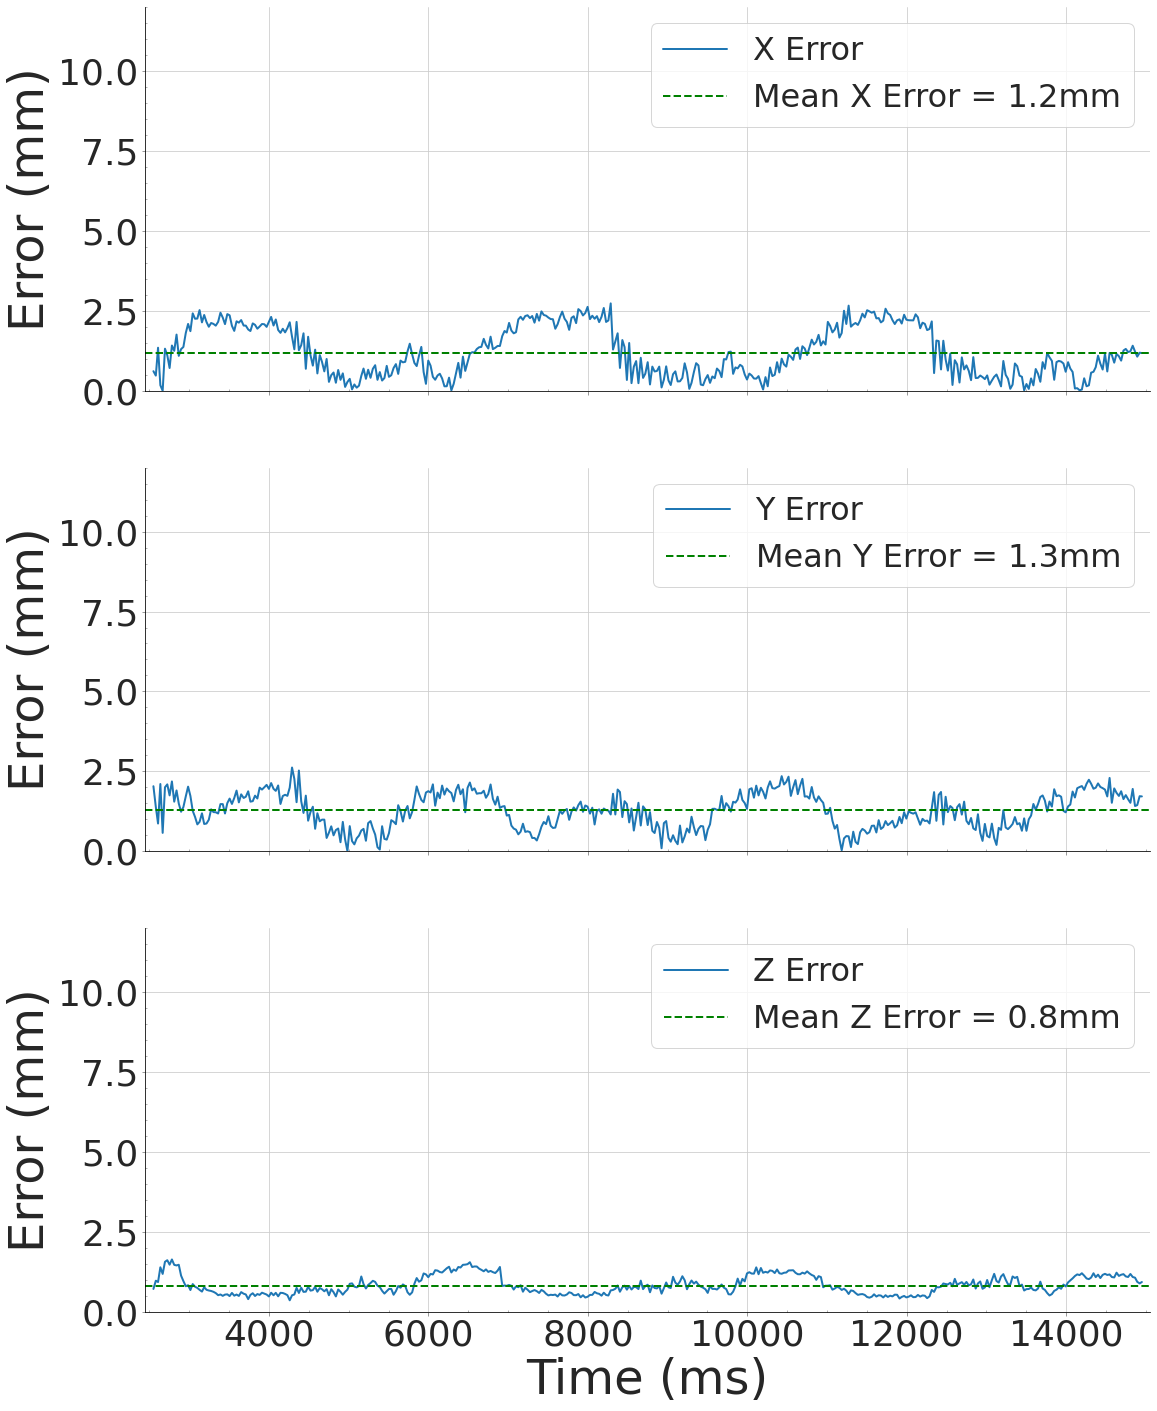

HM Sequence: Cardiac Motion Profile Error


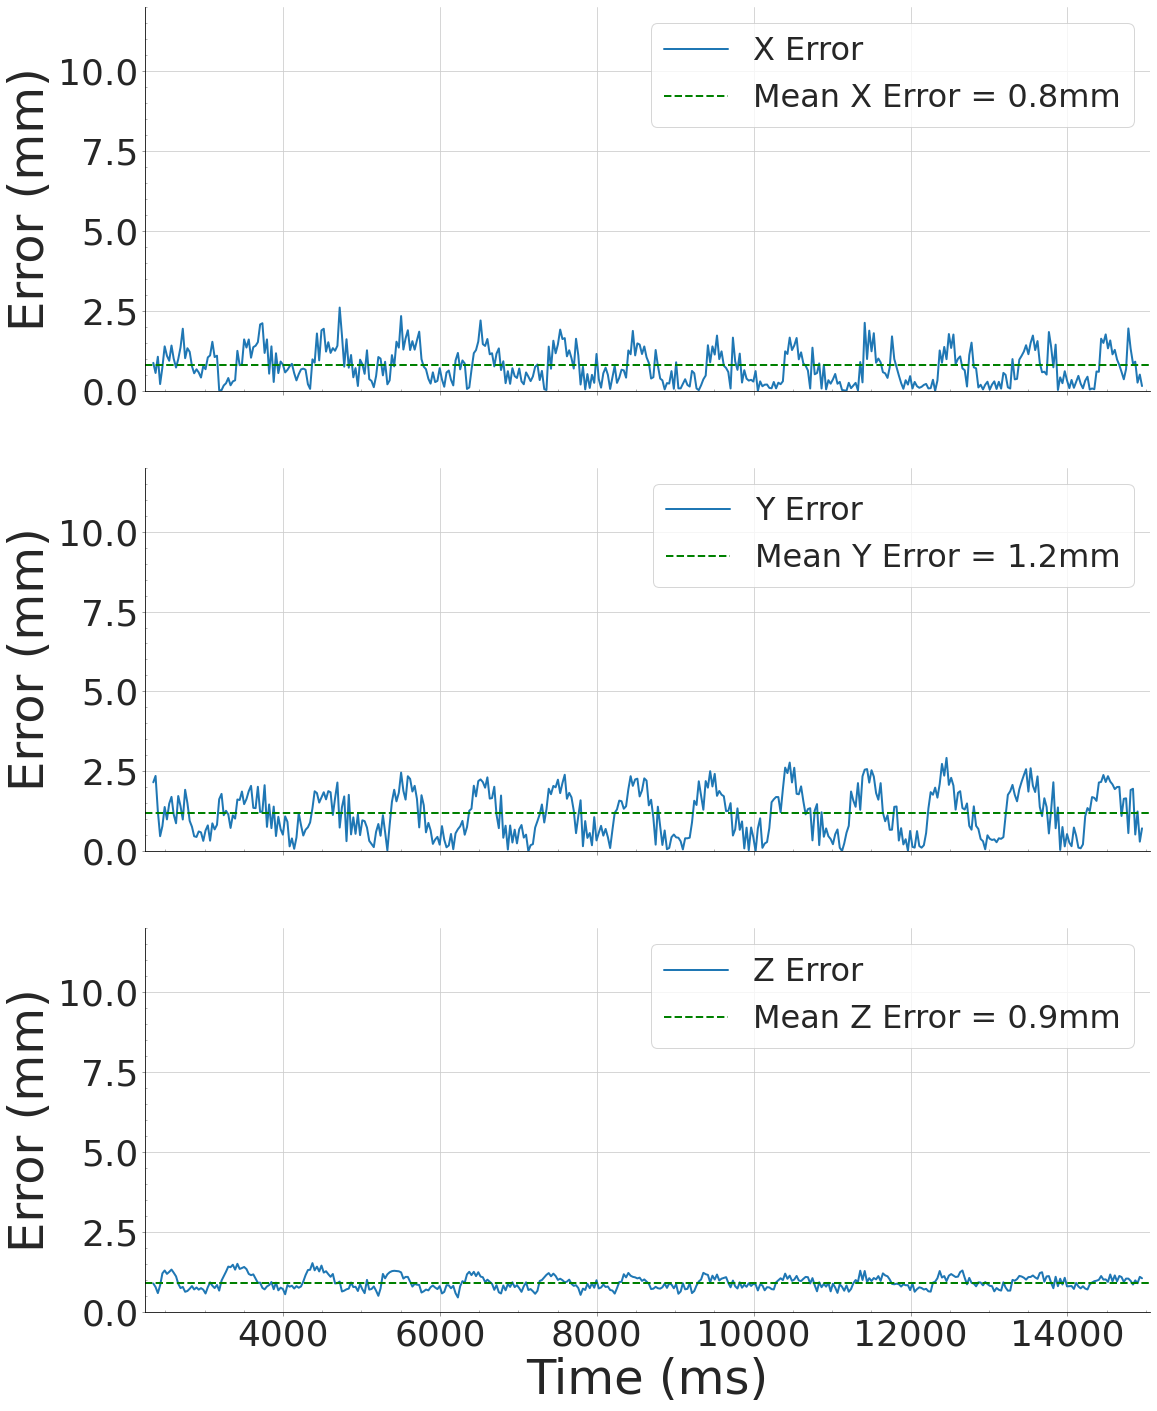

3P Sequence: Respiratory Motion Profile Error


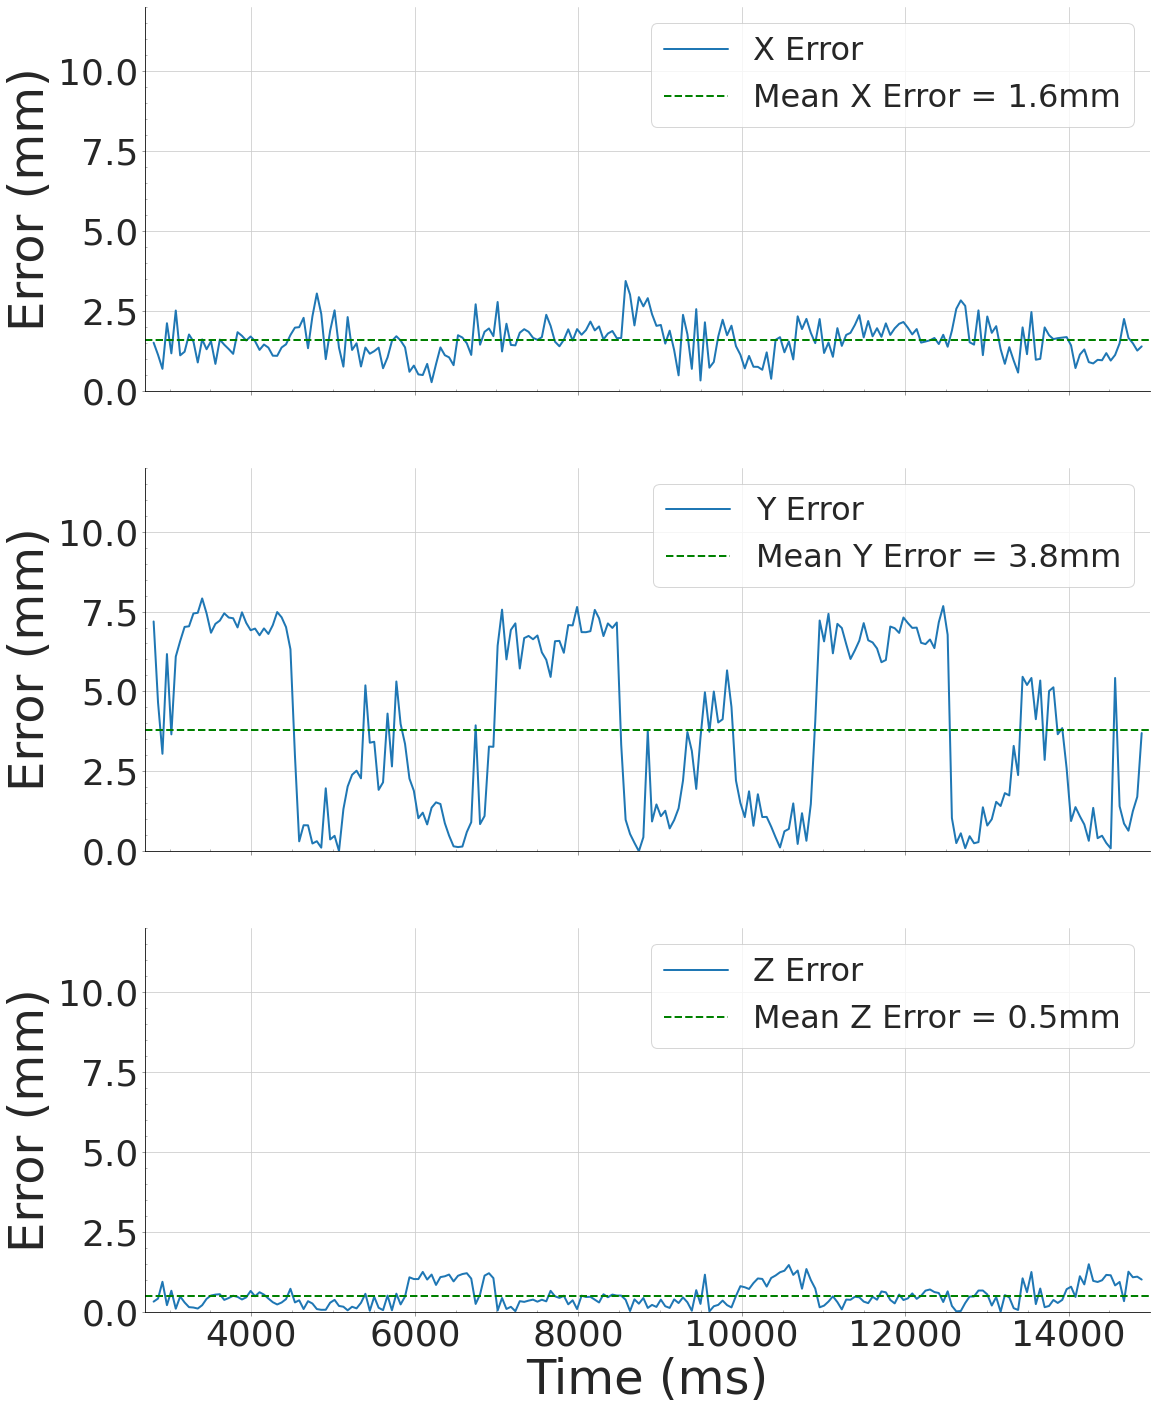

3P Sequence: Cardiac Motion Profile Error


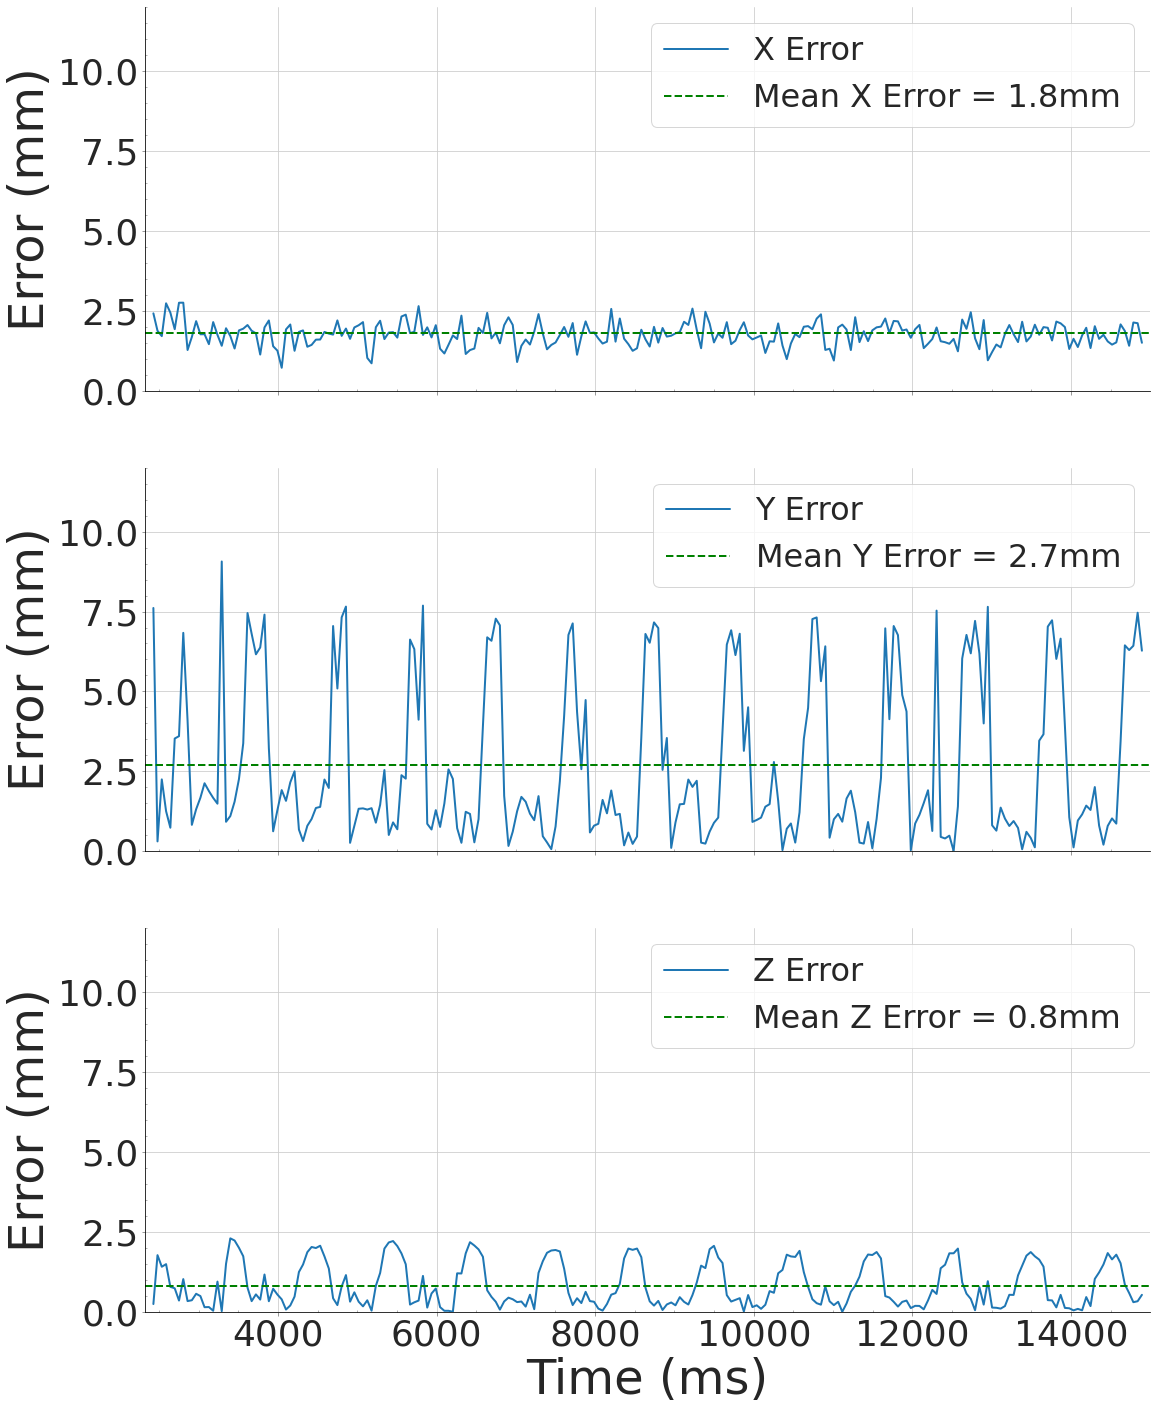

In [13]:
# # Plot error lineplots and save them to directory

# Sequence 1: Hadamard Multiplexed - JPNG
# plot_motion_error(FH512_2_jpng_7_231_resp, FH512_2_jpng_7_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_jpng_6_231_resp, FH512_2_jpng_6_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_jpng_tip_231_resp, FH512_2_jpng_tip_expected_231_resp, start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_jpng_7_231_card, FH512_2_jpng_7_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_jpng_6_231_card, FH512_2_jpng_6_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_jpng_tip_231_card, FH512_2_jpng_tip_expected_231_card, start_idx[0][1][sequences[0]], comparison_plot_paths[0])

# plot_motion_error(FH512_2_jpng_7_299_resp, FH512_2_jpng_7_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_jpng_6_299_resp, FH512_2_jpng_6_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
print("HM Sequence: Respiratory Motion Profile Error")
plot_motion_error(FH512_2_jpng_tip_299_resp, FH512_2_jpng_tip_expected_299_resp, start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_jpng_7_299_card, FH512_2_jpng_7_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_jpng_6_299_card, FH512_2_jpng_6_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
print("HM Sequence: Cardiac Motion Profile Error")
plot_motion_error(FH512_2_jpng_tip_299_card, FH512_2_jpng_tip_expected_299_card, start_idx[1][1][sequences[0]], comparison_plot_paths[1])

# plot_motion_error(FH512_2_jpng_7_306_resp, FH512_2_jpng_7_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_jpng_6_306_resp, FH512_2_jpng_6_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_jpng_tip_306_resp, FH512_2_jpng_tip_expected_306_resp, start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_jpng_7_306_card, FH512_2_jpng_7_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_jpng_6_306_card, FH512_2_jpng_6_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_jpng_tip_306_card, FH512_2_jpng_tip_expected_306_card, start_idx[2][1][sequences[0]], comparison_plot_paths[2])

# # Sequence 1: Hadamard Multiplexed - CAP
# plot_motion_error(FH512_2_cap_7_231_resp, FH512_2_cap_7_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_cap_6_231_resp, FH512_2_cap_6_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_cap_tip_231_resp, FH512_2_cap_tip_expected_231_resp, start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_cap_7_231_card, FH512_2_cap_7_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_cap_6_231_card, FH512_2_cap_6_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_cap_tip_231_card, FH512_2_cap_tip_expected_231_card, start_idx[0][1][sequences[0]], comparison_plot_paths[0])

# plot_motion_error(FH512_2_cap_7_299_resp, FH512_2_cap_7_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_cap_6_299_resp, FH512_2_cap_6_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_cap_tip_299_resp, FH512_2_cap_tip_expected_299_resp, start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_cap_7_299_card, FH512_2_cap_7_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_cap_6_299_card, FH512_2_cap_6_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_cap_tip_299_card, FH512_2_cap_tip_expected_299_card, start_idx[1][1][sequences[0]], comparison_plot_paths[1])

# plot_motion_error(FH512_2_cap_7_306_resp, FH512_2_cap_7_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_cap_6_306_resp, FH512_2_cap_6_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_cap_tip_306_resp, FH512_2_cap_tip_expected_306_resp, start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_cap_7_306_card, FH512_2_cap_7_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_cap_6_306_card, FH512_2_cap_6_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_cap_tip_306_card, FH512_2_cap_tip_expected_306_card, start_idx[2][1][sequences[0]], comparison_plot_paths[2])

# Sequence 2: Conventional - JPNG
# plot_motion_error(SRI_2_jpng_7_231_resp, SRI_2_jpng_7_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_jpng_6_231_resp, SRI_2_jpng_6_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_jpng_tip_231_resp, SRI_2_jpng_tip_expected_231_resp, start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_jpng_7_231_card, SRI_2_jpng_7_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_jpng_6_231_card, SRI_2_jpng_6_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_jpng_tip_231_card, SRI_2_jpng_tip_expected_231_card, start_idx[0][1][sequences[1]], comparison_plot_paths[0])

# plot_motion_error(SRI_2_jpng_7_299_resp, SRI_2_jpng_7_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_jpng_6_299_resp, SRI_2_jpng_6_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
print("3P Sequence: Respiratory Motion Profile Error")
plot_motion_error(SRI_2_jpng_tip_299_resp, SRI_2_jpng_tip_expected_299_resp, start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_jpng_7_299_card, SRI_2_jpng_7_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_jpng_6_299_card, SRI_2_jpng_6_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
print("3P Sequence: Cardiac Motion Profile Error")
plot_motion_error(SRI_2_jpng_tip_299_card, SRI_2_jpng_tip_expected_299_card, start_idx[1][1][sequences[1]], comparison_plot_paths[1])

# plot_motion_error(SRI_2_jpng_7_306_resp, SRI_2_jpng_7_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_jpng_6_306_resp, SRI_2_jpng_6_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_jpng_tip_306_resp, SRI_2_jpng_tip_expected_306_resp, start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_jpng_7_306_card, SRI_2_jpng_7_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_jpng_6_306_card, SRI_2_jpng_6_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_jpng_tip_306_card, SRI_2_jpng_tip_expected_306_card, start_idx[2][1][sequences[1]], comparison_plot_paths[2])

# # Sequence 2: Conventional - CAP
# plot_motion_error(SRI_2_cap_7_231_resp, SRI_2_cap_7_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_cap_6_231_resp, SRI_2_cap_6_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_cap_tip_231_resp, SRI_2_cap_tip_expected_231_resp, start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_cap_7_231_card, SRI_2_cap_7_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_cap_6_231_card, SRI_2_cap_6_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_cap_tip_231_card, SRI_2_cap_tip_expected_231_card, start_idx[0][1][sequences[1]], comparison_plot_paths[0])

# plot_motion_error(SRI_2_cap_7_299_resp, SRI_2_cap_7_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_cap_6_299_resp, SRI_2_cap_6_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_cap_tip_299_resp, SRI_2_cap_tip_expected_299_resp, start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_cap_7_299_card, SRI_2_cap_7_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_cap_6_299_card, SRI_2_cap_6_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_cap_tip_299_card, SRI_2_cap_tip_expected_299_card, start_idx[1][1][sequences[1]], comparison_plot_paths[1])

# plot_motion_error(SRI_2_cap_7_306_resp, SRI_2_cap_7_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_cap_6_306_resp, SRI_2_cap_6_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_cap_tip_306_resp, SRI_2_cap_tip_expected_306_resp, start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_cap_7_306_card, SRI_2_cap_7_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_cap_6_306_card, SRI_2_cap_6_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_cap_tip_306_card, SRI_2_cap_tip_expected_306_card, start_idx[2][1][sequences[1]], comparison_plot_paths[2])

# Generate Error Boxplots

Respiratory Motion Profile: JPNG Tip Error


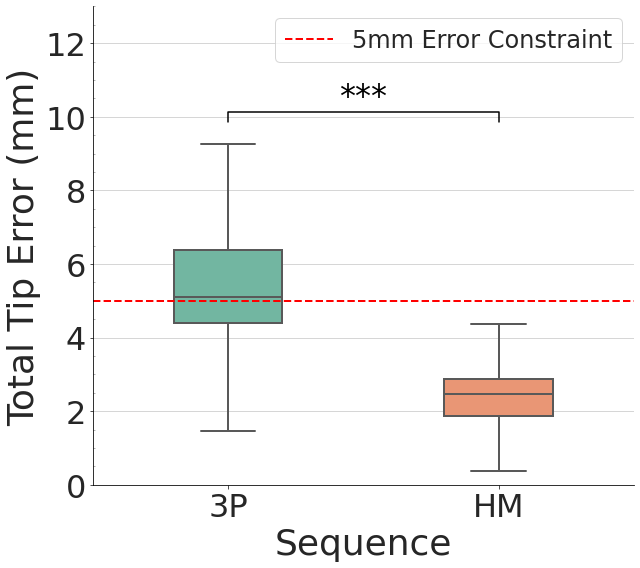

Cardiac Motion Profile: JPNG Tip Error


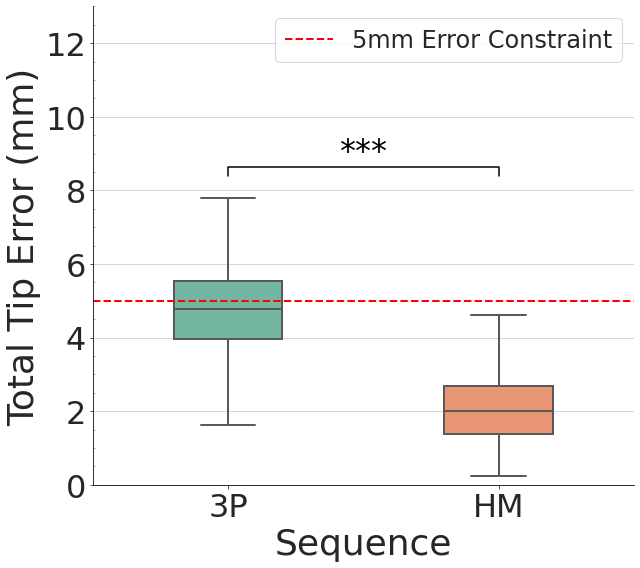

In [14]:
# Merge data for error boxplots, plot them, and save them to directory

plot_df_resp = merge_plot_dfs([SRI_2_jpng_plot_df_231_resp, SRI_2_jpng_plot_df_299_resp, SRI_2_jpng_plot_df_306_resp, FH512_2_jpng_plot_df_231_resp, FH512_2_jpng_plot_df_299_resp, FH512_2_jpng_plot_df_306_resp])
plot_df_card = merge_plot_dfs([SRI_2_jpng_plot_df_231_card, SRI_2_jpng_plot_df_299_card, SRI_2_jpng_plot_df_306_card, FH512_2_jpng_plot_df_231_card, FH512_2_jpng_plot_df_299_card, FH512_2_jpng_plot_df_306_card])

print("Respiratory Motion Profile: JPNG Tip Error")
plot_error_box_plot(plot_df_resp, box_plot_path, sequences)

print("Cardiac Motion Profile: JPNG Tip Error")
plot_error_box_plot(plot_df_card, box_plot_path, sequences)

In [15]:
print('Respiratory Motion results')
resp_hm_mean = plot_df_resp[plot_df_resp['Sequence']=='HM']['Total Error'].mean()
resp_hm_std = plot_df_resp[plot_df_resp['Sequence']=='HM']['Total Error'].std()


resp_3p_mean = plot_df_resp[plot_df_resp['Sequence']=='3P']['Total Error'].mean()
resp_3p_std = plot_df_resp[plot_df_resp['Sequence']=='3P']['Total Error'].std()

print(f'\tHM: Mean Error = {resp_hm_mean} mm, SD = {resp_hm_std} mm')
print(f'\t3P: Mean Error = {resp_3p_mean} mm, SD = {resp_3p_std} mm')

print('Cardiac Motion results')
card_hm_mean = plot_df_card[plot_df_card['Sequence']=='HM']['Total Error'].mean()
card_hm_std = plot_df_card[plot_df_card['Sequence']=='HM']['Total Error'].std()


card_3p_mean = plot_df_card[plot_df_card['Sequence']=='3P']['Total Error'].mean()
card_3p_std = plot_df_card[plot_df_card['Sequence']=='3P']['Total Error'].std()

print(f'\tHM: Mean Error = {card_hm_mean} mm, SD = {card_hm_std} mm')
print(f'\t3P: Mean Error = {card_3p_mean} mm, SD = {card_3p_std} mm')


Respiratory Motion results
	HM: Mean Error = 2.541436244635775 mm, SD = 1.2252977652682508 mm
	3P: Mean Error = 5.252253279223336 mm, SD = 1.9826054455882396 mm
Cardiac Motion results
	HM: Mean Error = 2.4488700710972844 mm, SD = 1.8907595207288823 mm
	3P: Mean Error = 4.6965796685977 mm, SD = 1.5972620707907712 mm


# HDF5 Exports
Each of the error dataframes - named according to sequence, algorithm, catheter, and motion profile - has been saved as a group into the dynamic_tracking_tip_errors.h5 file. To examine a particular data frame, use the pandas [read_hdf](https://pandas.pydata.org/docs/reference/api/pandas.read_hdf.html) method as shown below:

In [16]:
pd.read_hdf(h5out, key="C3P_CAP_cath306_cardiac")

,Algorithm,Catheter,Coil,Error in X,Error in Y,Error in Z,Profile,Sequence,Time,Total Error,Tracked X,Tracked Y,Tracked Z
0,centroid_around_peak,Catheter 3,Tip,2.957008,2.529120,0.876296,Cardiac Profile (60 bpm),3P,1675.0,3.988514,-28.278755,78.110925,-46.975539
1,centroid_around_peak,Catheter 3,Tip,2.838211,2.693052,0.397864,Cardiac Profile (60 bpm),3P,1729.0,3.932717,-28.131271,77.947117,-45.799667
2,centroid_around_peak,Catheter 3,Tip,4.386346,1.939057,0.432162,Cardiac Profile (60 bpm),3P,1783.0,4.815261,-29.653952,78.701222,-44.297465
3,centroid_around_peak,Catheter 3,Tip,4.610771,1.938575,1.313866,Cardiac Profile (60 bpm),3P,1835.0,5.171414,-29.859602,78.701786,-42.333101
4,centroid_around_peak,Catheter 3,Tip,4.742315,2.191525,1.295040,Cardiac Profile (60 bpm),3P,1889.0,5.382329,-29.979739,78.448884,-41.694041
...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,centroid_around_peak,Catheter 3,Tip,3.181788,1.485790,0.782305,Cardiac Profile (60 bpm),3P,14680.0,3.597687,-28.541705,79.154089,-49.270718
242,centroid_around_peak,Catheter 3,Tip,2.148294,2.215570,0.233376,Cardiac Profile (60 bpm),3P,14734.0,3.094896,-27.480304,78.424430,-48.210321
243,centroid_around_peak,Catheter 3,Tip,2.375372,2.100667,0.485241,Cardiac Profile (60 bpm),3P,14788.0,3.207905,-27.678319,78.539459,-46.282442
244,centroid_around_peak,Catheter 3,Tip,2.658906,2.415799,0.856423,Cardiac Profile (60 bpm),3P,14841.0,3.693146,-27.935369,78.224441,-44.383978
